In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import fastf1
from fastf1 import plotting
from scipy.interpolate import interp1d

In [2]:
fastf1.Cache.enable_cache('./f1_cache')
fastf1.Cache.get_cache_info()

('./f1_cache', 2598705762)

In [3]:
session = fastf1.get_session(2025, 13, 'Sprint Qualifying')
session.load()

core           INFO 	Loading data for Belgian Grand Prix - Sprint Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core        WARNING 	Sprint Qualifying is not supported by Ergast! Limited results are calculated from timing data.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '4', '16', '31', '55', '87', '10', '6', '5', '30', '22', '63', '14', '18', '23', '27', '44'

In [4]:
pia_color = plotting.get_driver_color(session=session,identifier='PIA')
ver_color = plotting.get_driver_color(session=session,identifier='VER')

req            INFO 	Using cached data for driver_info


In [5]:
ver_df = session.laps.pick_drivers('VER').pick_fastest().telemetry[['Time','Distance','X','Y']]
pia_df = session.laps.pick_drivers('PIA').pick_fastest().telemetry[['Time','Distance','X','Y']]

In [6]:
ver_df['Seconds'] = ver_df['Time'].dt.total_seconds()
pia_df['Seconds'] = pia_df['Time'].dt.total_seconds()

In [8]:
# Verstappen
ver_time_interp = interp1d(ver_df['Distance'], ver_df['Seconds'], kind='linear', bounds_error=False, fill_value="extrapolate")
ver_x_interp    = interp1d(ver_df['Distance'], ver_df['X'], kind='linear', bounds_error=False, fill_value="extrapolate")
ver_y_interp    = interp1d(ver_df['Distance'], ver_df['Y'], kind='linear', bounds_error=False, fill_value="extrapolate")

# Piastri
pia_time_interp = interp1d(pia_df['Distance'], pia_df['Seconds'], kind='linear', bounds_error=False, fill_value="extrapolate")
pia_x_interp    = interp1d(pia_df['Distance'], pia_df['X'], kind='linear', bounds_error=False, fill_value="extrapolate")
pia_y_interp    = interp1d(pia_df['Distance'], pia_df['Y'], kind='linear', bounds_error=False, fill_value="extrapolate")

In [9]:
min_dist = max(pia_df['Distance'].min(), ver_df['Distance'].min())
max_dist = min(pia_df['Distance'].max(), ver_df['Distance'].max())

distance_grid = np.linspace(min_dist, max_dist, num=7000)  # adjust num=3000 for resolution

In [10]:
# Interpolated cumulative time
ver_time = ver_time_interp(distance_grid)
pia_time = pia_time_interp(distance_grid)

# Interpolated positions
y = (ver_x_interp(distance_grid) + pia_x_interp(distance_grid)) / 2
x = -(ver_y_interp(distance_grid) + pia_y_interp(distance_grid)) / 2

In [11]:
delta = pia_time - ver_time  # Negative -> Piastri faster

# Assign colors
colors = np.where(delta < 0, pia_color, ver_color)

In [12]:
# Create line segments
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

In [23]:
import matplotlib.patches as mpatches

# Create legend handles manually
pia_patch = mpatches.Patch(color=pia_color, label='Piastri faster')
ver_patch = mpatches.Patch(color=ver_color, label='Verstappen faster')

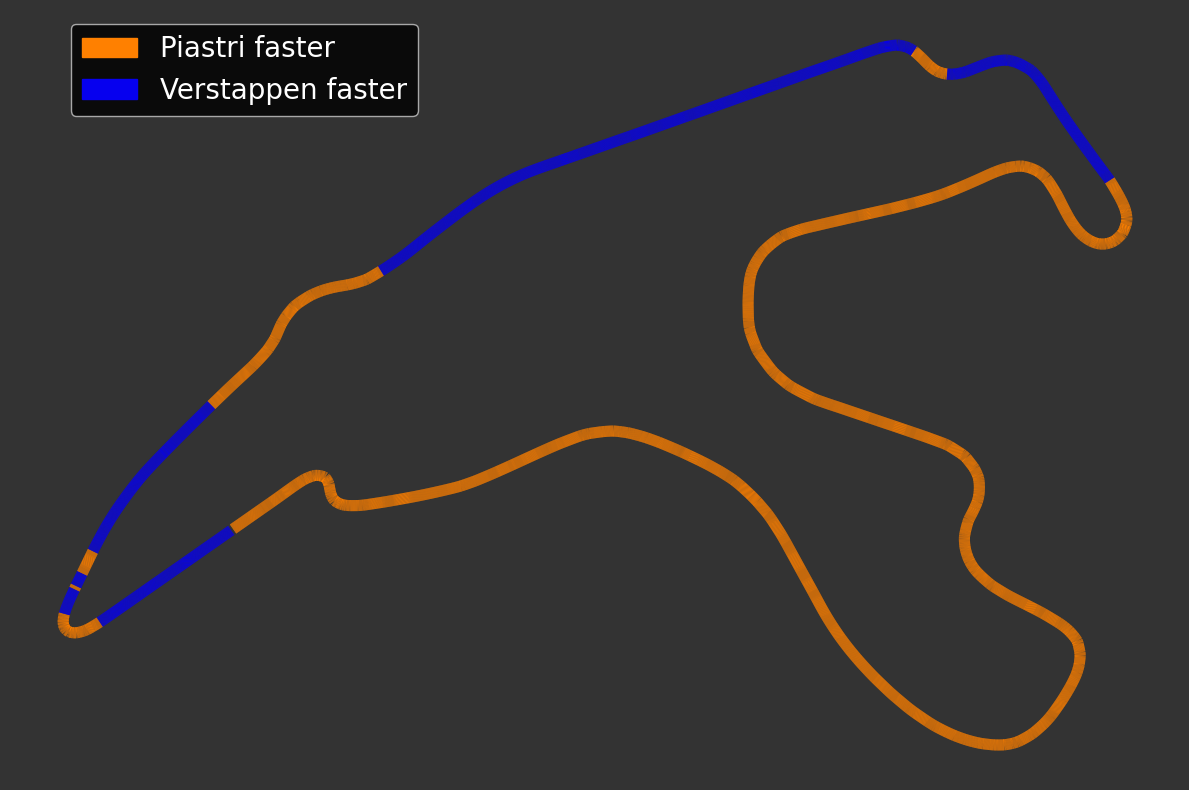

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor('#333333')
ax.axis('off')

# Color per segment (drop last color to match segments length)
lc = LineCollection(segments, colors=colors[:-1], linewidth=8)

ax.add_collection(lc)
ax.autoscale()

# Add legend to your axes
ax.legend(handles=[pia_patch, ver_patch],
          loc='upper left',  # or any location you prefer
          bbox_to_anchor=(0.04,1),
          frameon=True,
          facecolor='k',
          fontsize=20,
          labelcolor='white')

plt.tight_layout()
plt.show()